In [1]:
import random
import numpy as np
from scipy.stats import binom
import matplotlib.pyplot as plt
from scipy.special import erfinv
from scipy.integrate import quad
from scipy.stats import poisson, chi2
from iminuit import Minuit
%matplotlib inline

## Utility functions

In [2]:
def find_max(function, bound_low, bound_high, grid=100000,):
    """
    Return the maximum value of a function
    """
    if (not grid >= 0):
        raise ValueError("Grid must be a a positive intiger")
    # Generate grid of x values
    x = np.linspace(bound_low, bound_high, num=grid, endpoint=True,)
    y = function(x)
    return y.max()

## PDF Classes

In [3]:
class ProbabilityDensityFunction(object):
    """
    Parent class containing common methods and members to be used by all pdf classes
    """

    def __init__(self, bounds):

        if (not isinstance(bounds, tuple)):
            raise TypeError("Variable bound must be a tuple with the form (boundMin, boundMax)")
        if (not len(bounds) == 2):
            raise ValueError("Variable bound must have form (boundMin, boundMax)")
        if (not bounds[0] < bounds[1]):
            raise ValueError("First element in tuple must be smaller than second")
        
        # Initialise class variables
        self.boundMin, self.boundMax = bounds

    def integrate(self, limits):
        """
        Evaluate the integral of the pdf within the specified bounds
        ##### NOTE: Integral is not normalised within the specified bounds of the class #####
        """

        if (not isinstance(limits, tuple)):
            raise TypeError("Variable bound must be a tuple with the form (limitMin, limitMax)")
        if (not len(limits) == 2):
            raise ValueError("Variable bound must have form (limitMin, limitMax)")
        if (not limits[0] < limits[1]):
            raise ValueError("First element in tuple must be smaller than second")
        if (not limits[0] >= self.boundMin):
            raise ValueError("Lower integral limit must be larger than lower bound of pdf")
        if (not limits[1] <= self.boundMax):
            raise ValueError("Higher integral limit must be smaller than upper bound of pdf")
    
        lowerLimit, upperLimit = limits
        integralResult, IntegralError = quad(self._evaluate, lowerLimit, upperLimit) 
        return integralResult

class Gaussian(ProbabilityDensityFunction):
    """
    Class that contains a variable function for a Gaussian
    """

    def __init__(self, mean, sigma, bounds):

        # Initialise parent class
        super().__init__(bounds)
        
        # Initialise class variables
        self.mean = mean
        self.sigma = sigma
        # Find maximum value of the distribution within the bounds
        self.maxValue = find_max(self._evaluate, self.boundMin, self.boundMax)

    def _evaluate(self, x,):
        """
        Evaluate the gaussian function of the distribution
        ##### NOTE: Returns un-normalised values between the bounds #####
        """

        return 1/(self.sigma * np.sqrt(2.0*np.pi)) * np.exp( -(x-self.mean)**2 / (2.0 * self.sigma**2) )

    def setParameters(self, mean=None, sigma=None):
        """
        Set passed variables as parameters for pdf
        """

        # Use default values for parameters of none are passed through kwargs
        if not mean == None:                self.mean = mean 
        if not sigma == None:               self.sigma = sigma

class Linear(ProbabilityDensityFunction):
    """
    Class that contains a variable function for a  Linear function
    """

    def __init__(self, slope, intercept, bounds):

        # Initialise parent class
        super().__init__(bounds)

        # Initialise class variables
        self.intercept = intercept
        self.slope = slope
        # Find maximum value of the distribution within the bounds
        self.maxValue = find_max(self._evaluate, self.boundMin, self.boundMax)

    def _evaluate(self, x,):
        """
        Evaluate the linear function of the distribution
        NOTE: Returns un-normalised values
        """
        
        return self.intercept + self.slope * x

    def setParameters(self, slope=None, intercept=None):
        """
        Set passed variables as parameters for pdf
        """

        # Use default values for parameters of none are passed through kwargs
        if not slope == None:                   self.slope = slope
        if not intercept == None:               self.intercept = intercept       

class SecondOrderPolynomial(ProbabilityDensityFunction):
    """
    Class that contains a variable function for a 2nd order polinomial
    """

    def __init__(self, alpha, beta, gamma, bounds):

        # Initialise parent class
        super().__init__(bounds)

        # Initialise class variables
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        # Find maximum value of the distribution within the bounds
        self.maxValue = find_max(self._evaluate, self.boundMin, self.boundMax)

    def _evaluate(self, x,):
        """
        Evaluate the linear function of the distribution
        NOTE: Returns un-normalised values
        """
        
        return self.alpha*x**2 + self.beta*x + self.gamma

    def setParameters(self, alpha=None, beta=None, gamma=None):
        """
        Set passed variables as parameters for pdf
        """

        # Use default values for parameters of none are passed through kwargs
        if not alpha == None:                   self.alpha = alpha
        if not beta == None:                    self.beta = beta 
        if not gamma == None:                   self.gamma = gamma

class Exponential(ProbabilityDensityFunction):
    """
    Class that contains a variable function for an exponential
    """

    def __init__(self, decayConstant, bounds):

        # Initialise parent class
        super().__init__(bounds)

        # Initialise class variables
        self.decayConstant = decayConstant
        # Find maximum value of the distribution within the bounds
        self.maxValue = find_max(self._evaluate, self.boundMin, self.boundMax)

    def _evaluate(self, x,):
        """
        Evaluate the linear function of the distribution
        NOTE: Returns un-normalised values
        """
        
        return np.exp(-x/self.decayConstant)

    def setParameters(self, decayConstant=None):
        """
        Set passed variables as parameters for pdf
        """

        # Use default values for parameters of none are passed through kwargs
        if not decayConstant == None:                   self.decayConstant = decayConstant

class GaussianWithLinear(ProbabilityDensityFunction):
    """
    Class that will generate a varuable function consisting of gaussian signal with a linear background 
    """

    def __init__(self, backgroundFraction, mean, sigma, slope, intercept, bounds,):
        
        # Initialise parent class
        super().__init__(bounds)

        self.backgroundFraction = backgroundFraction
    
        # Initialise pdf objects
        self.signal = Gaussian(mean, sigma, bounds)
        self.background = Linear(slope, intercept, bounds)

    def _evaluate(self, x,):
        """
        Evaluate the function of the distribution
        NOTE: Returns un-normalised values between the bounds
        """

        return (1-self.backgroundFraction)*self.signal._evaluate(x,) + \
                self.backgroundFraction*self.background._evaluate(x,) 

    def setParameters(self, backgroundFraction=None, mean=None, sigma=None, slope=None, intercept=None):
        """
        Set passed variables as parameters for pdf
        """

        # Update parameters to variables that have been passed through the method
        if not backgroundFraction == None:      self.backgroundFraction = backgroundFraction
        if not mean == None:                self.signal.mean = mean
        if not sigma == None:               self.signal.sigma = sigma 
        if not slope == None:               self.background.slope = slope
        if not intercept == None:           self.background.intercept = intercept

class GaussianWithPolinomial(ProbabilityDensityFunction):
    """
    Class that will generate a varuable function consisting of gaussian signal with a second order polinomial background 
    """

    def __init__(self, backgroundFraction, mean, sigma, alpha, beta, gamma, bounds):
        
        # Initialise parent class
        super().__init__(bounds)

        self.backgroundFraction = backgroundFraction
    
        # Initialise pdf objects
        self.signal = Gaussian(mean, sigma, bounds)
        self.background = SecondOrderPolynomial(alpha, beta, gamma, bounds)

    def _evaluate(self, x,):
        """
        Evaluate the function of the distribution
        NOTE: Returns un-normalised values between the bounds
        """

        return (1-self.backgroundFraction)*self.signal._evaluate(x,) + \
                self.backgroundFraction*self.background._evaluate(x,) 

    def setParameters(self, backgroundFraction=None, mean=None, sigma=None, alpha=None, beta=None, gamma=None):
        """
        Set passed variables as parameters for pdf
        """

        # Update parameters to variables that have been passed through the method
        if not backgroundFraction == None:  self.backgroundFraction = backgroundFraction
        if not mean == None:                self.signal.mean = mean
        if not sigma == None:               self.signal.sigma = sigma 
        if not alpha == None:               self.background.alpha = alpha
        if not beta == None:                self.background.beta = beta 
        if not gamma == None:               self.background.gamma = gamma

class GaussianWithExponential(ProbabilityDensityFunction):
    """
    Class that will generate a varuable function consisting of gaussian signal with an exponential background 
    """

    def __init__(self, backgroundFraction, mean, sigma, decayConstant, bounds):
        
        # Initialise parent class
        super().__init__(bounds)

        self.backgroundFraction = backgroundFraction
    
        # Initialise pdf objects
        self.signal = Gaussian(mean, sigma, bounds)
        self.background = Exponential(decayConstant, bounds)

    def _evaluate(self, x,):
        """
        Evaluate the function of the distribution
        NOTE: Returns un-normalised values between the bounds
        """

        return (1-self.backgroundFraction)*self.signal._evaluate(x,) + \
                self.backgroundFraction*self.background._evaluate(x,) 

    def setParameters(self,backgroundFraction=None, mean=None, sigma=None, decayConstant=None):
        """
        Set passed variables as parameters for pdf
        """

        # Update parameters to variables that have been passed through the method
        if not backgroundFraction == None:  self.backgroundFraction = backgroundFraction
        if not mean == None:                self.signal.mean = mean
        if not sigma == None:               self.signal.sigma = sigma 
        if not decayConstant == None:       self.background.decayConstant = decayConstant

## Minimisation classes

In [4]:
class NegativeLogLikelihood(object):
    """
    Class containing minimisation statistic to be for pdf fitting. The class takes in events as the input.
    """

    def __init__(self, pdf, data):

        self.pdf = pdf
        self.data = data

    def setData(self, data):
        """
        Assign data class member to new dataset for the reuse of this class
        """
        
        self.data = data

    def findNormalisationFactor(self,):
        """
        Find integral of pdf 
        """
        
        # Define integration limits
        normalisationLimits = (self.pdf.boundMin, self.pdf.boundMax)

        return self.pdf.integrate(normalisationLimits)

    def evaluateSignalWithExponential(self, backgroundFraction, mean, sigma, decayConstant):
        """
        Evaluate negative log likelihood statisctic for passed parameters
        """

        # set new parameters
        self.pdf.setParameters(backgroundFraction=backgroundFraction, mean=mean, sigma=sigma, decayConstant=decayConstant,)

        # compute likelyhood using passed parameters
        normalisation = self.pdf.integrate((self.pdf.boundMin, self.pdf.boundMax))
        likelihood = self.pdf._evaluate(self.data,) / normalisation
        # set any negative likelihoods to neglegable positive values
        if (likelihood <= 0).any():
            likelihood[likelihood <=0 ] = 1e-10
        loglikelihood = np.log(likelihood)
        return -loglikelihood.sum()

    def evaluateSignalWithPolynomial(self, backgroundFraction, mean, sigma, alpha, beta, gamma,):
        """
        Evaluate negative log likelihood statisctic for passed parameters
        """

        # set new parameters
        self.pdf.setParameters(
            backgroundFraction=backgroundFraction, mean=mean, sigma=sigma, alpha=alpha, beta=beta, gamma=gamma,
        )

        # compute likelyhood using passed parameters
        normalisation = self.pdf.integrate((self.pdf.boundMin, self.pdf.boundMax))
        likelihood = self.pdf._evaluate(self.data,) / normalisation
        # set any negative likelihoods to neglegable positive values
        if (likelihood <= 0).any():
            likelihood[likelihood <=0 ] = 1e-10
        loglikelihood = np.log(likelihood)
        return -loglikelihood.sum()

    def evaluateSignalWithLinear(self, backgroundFraction, mean, sigma, slope, intercept):
        """
        Evaluate negative log likelihood statisctic for passed parameters
        """

        # set new parameters
        self.pdf.setParameters(
            backgroundFraction=backgroundFraction, mean=mean, sigma=sigma, slope=slope, intercept=intercept,
        )

        # compute likelyhood using passed parameters
        normalisation = self.pdf.integrate((self.pdf.boundMin, self.pdf.boundMax))
        likelihood = self.pdf._evaluate(self.data,) / normalisation
        # set any negative likelihoods to neglegable positive values
        if (likelihood <= 0).any():
            likelihood[likelihood <=0 ] = 1e-10
        loglikelihood = np.log(likelihood)
        return -loglikelihood.sum()

## Question 1

In [5]:
# Load in the higgs dataset
filename = "datafile-higgs.txt"
events = np.loadtxt(filename)
n_events = events.size
print(f"The number of events in dataset is: {n_events}")

The number of events in dataset is: 100000


In [6]:
# Define constants to be used througout the analysis
X_BOUNDS = (0.0, 10.0)
N_BINS = 70
X_VALUES = np.linspace(*X_BOUNDS, N_BINS, endpoint=True)

We can plot the dataset to visualise the distribution

Text(0.5, 1.0, 'Histogram of measured events in range $\\in$ [0, 10]')

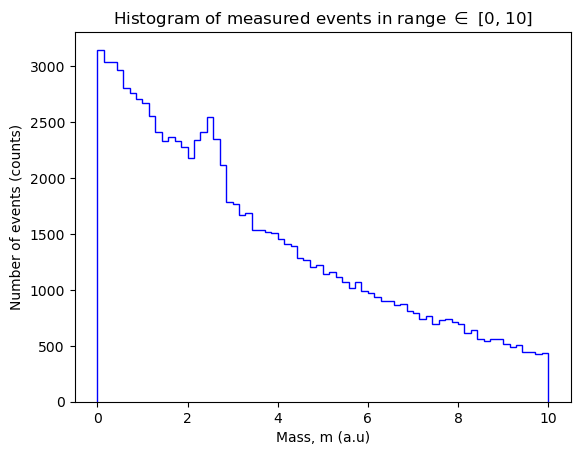

In [7]:
# Plot histogram
plt.hist(events, bins=N_BINS, histtype="step", color="blue",) 
plt.xlabel("Mass, m (a.u)")
plt.ylabel(f"Number of events (counts)")
plt.title(r"Histogram of measured events in range $\in$ [0, 10]")

We will now attempt to fit the data with a gaussian signal + exponential background.

We expect the parameter values to be around:
* Background fraction = 0.98
* Mean = 2.5
* Sigma = 0.2
* Decay constant = 5 

In [8]:
# Define initial parameters of fit in a dictionary
initial_parameter_dict = {
    "backgroundFraction":       0.9,
    "mean":                     2.0,
    "sigma":                    0.5,
    "decayConstant":            4.5,   
}

# Initialise objects for pdf (object with function we want to fit) and the fitting statistic (nnl)
# We set the values of the parameter when initialising object to 1 as they will be overritien by the init param dict
fit_function = GaussianWithExponential(backgroundFraction=1.0, mean=1.0, sigma=1.0, decayConstant=1.0, bounds=X_BOUNDS,)
fit_statistic = NegativeLogLikelihood(fit_function, events)

# Initialise iminuit minimiser object
minimiser = Minuit(
    fit_statistic.evaluateSignalWithExponential,
    **initial_parameter_dict,
)
# Set the error diff to 0.5 as we are using negative log likelyhood
minimiser.errordef = 0.5
# Minimise the fit_statistic
result = minimiser.migrad()
# Output minimisation results
result

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2.146e+05                  │              Nfcn = 158              │
│ EDM = 4.25e-06 (Goal: 0.0001)    │            time = 0.5 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name               │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ backgroundFraction │   0.918   │   0.005   │            │            │         │         │       │
│ 1 │ mean               │   2.499   │   0.014   │            │            │         │         │       │
│ 2 │ sigma              │   0.195   │   0.014   │            │            │         │         │       │
│ 3 │ decayConstant      │   5.007   │   0.031   │            │            │         │         │       │
└───┴────────────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────────────────┬─────────────────────────────────────────────────────────────────────────────┐
│                    │ backgroundFraction               mean              sigma      decayConstant │
├────────────────────┼─────────────────────────────────────────────────────────────────────────────┤
│ backgroundFraction │           2.72e-05           0.008e-3          -0.040e-3          -0.032e-3 │
│               mean │           0.008e-3            0.00021           -0.02e-3           -0.02e-3 │
│              sigma │          -0.040e-3           -0.02e-3           0.000201            0.04e-3 │
│      decayConstant │          -0.032e-3           -0.02e-3            0.04e-3           0.000951 │
└────────────────────┴─────────────────────────────────────────────────────────────────────────────┘

In [9]:
# Define list containing all parameter names
parameter_names = initial_parameter_dict.keys()
# Define list containing all optimised parameter values
optimised_parameter_vals = [result.values[key] for key in parameter_names]
# Define list containing all optimised parameter errors
optimised_parameter_errors = [result.errors[key] for key in parameter_names]
# Define liust containing units of each parameter
parameter_units = ["", "a.u", "a.u", ""]

# Print out results
for idx, name in enumerate(parameter_names):
    print(f"The optimised value of mean +/- statistical error is:  {optimised_parameter_vals[idx]:.2f} +/- {optimised_parameter_errors[idx]:.2f} {parameter_units[idx]}\n")

The optimised value of mean +/- statistical error is:  0.92 +/- 0.01 

The optimised value of mean +/- statistical error is:  2.50 +/- 0.01 a.u

The optimised value of mean +/- statistical error is:  0.20 +/- 0.01 a.u

The optimised value of mean +/- statistical error is:  5.01 +/- 0.03 



We will prepare a dictionary to hold the stastistical errors of the mean for different fitting models in order to compute the systematic errors on our optimised parameter

In [10]:
# dictionary to hold statistical error of the mean for each model
mean_statistical_errors = {
    "gaussian_with_exponential":       result.errors["mean"]
}

# Dictionary to hold the minimised mean parameter for all fitss
optimised_means = {
    "gaussian_with_exponential":       result.values["mean"]
}

Plot the distribution allong with the fit

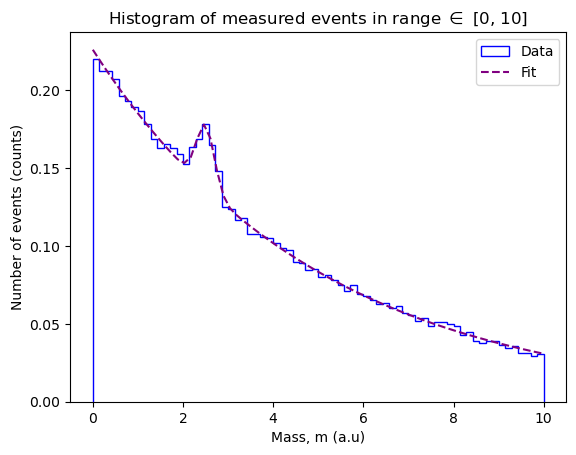

In [11]:
# Compute the predictied y values of the fit (Values are normalised)
fit_line = fit_function._evaluate(X_VALUES) / fit_function.integrate(X_BOUNDS)

# Plot histogram with fit
plt.hist(events, bins=N_BINS, histtype="step", color="blue", label="Data", density=True) 
plt.plot(X_VALUES, fit_line, ls="--", c="purple", label="Fit")
plt.xlabel("Mass, m (a.u)")
plt.ylabel(f"Number of events (counts)")
plt.title(r"Histogram of measured events in range $\in$ [0, 10]")
plt.legend()

## Question 2

We will now attempt to fit the data with a gaussian signal + exponential background.

We expect the parameter values to be around:
* Background fraction = 0.98
* Mean = 2.5
* alpha/gamma = -0.16
* beta/gamma = 0.007
* We fix gamma = 1  

In [12]:
# Define initial parameters of fit in a dictionary
initial_parameter_dict = {
    "backgroundFraction":       0.9,
    "mean":                     2.0,
    "sigma":                    0.5,
    "alpha":                    0.007,
    "beta":                     -0.1,
    "gamma":                    1.0,
}

# Initialise objects for pdf (object with function we want to fit) and the fitting statistic (nnl)
# We set the values of the parameter when initialising object to 1 as they will be overritien by the init param dict
fit_function = GaussianWithPolinomial(
    backgroundFraction=1.0, mean=1.0, sigma=1.0, alpha=1.0, beta=1.0, gamma=1.0, bounds=X_BOUNDS,
)
fit_statistic = NegativeLogLikelihood(fit_function, events)

# Initialise iminuit minimiser object
minimiser = Minuit(
    fit_statistic.evaluateSignalWithPolynomial,
    **initial_parameter_dict,
)
# Set the error diff to 0.5 as we are using negative log likelyhood
minimiser.errordef = 0.5

# Fix the value of gamma to 1.0
minimiser.fixed["gamma"] = True

# Apply resonable limits to parameters
minimiser.limits = [(0.7, 1.0), (2.0, 3.0), (0.0, 0.4), (None, None), (None, None), (None, None)] 

# Minimise the fit_statistic
result = minimiser.migrad()

# Output minimisation results
result

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2.146e+05                  │              Nfcn = 246              │
│ EDM = 9.45e-06 (Goal: 0.0001)    │            time = 0.6 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name               │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ backgroundFraction │   0.928   │   0.005   │            │            │   0.7   │    1    │       │
│ 1 │ mean               │   2.498   │   0.015   │            │            │    2    │    3    │       │
│ 2 │ sigma              │   0.175   │   0.014   │            │            │    0    │   0.4   │       │
│ 3 │ alpha              │  7.30e-3  │  0.15e-3  │            │            │         │         │       │
│ 4 │ beta               │  -0.1578  │  0.0014   │            │            │         │         │       │
│ 5 │ gamma              │   1.00    │   0.01    │            │            │         │         │  yes  │
└───┴────────────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────────────────┬───────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│                    │ backgroundFraction               mean              sigma              alpha               beta              gamma │
├────────────────────┼───────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│ backgroundFraction │           2.81e-05           0.011e-3          -0.038e-3           0.040e-6            -0.6e-6                  0 │
│               mean │           0.011e-3           0.000238           -0.03e-3           0.079e-6            -1.0e-6                  0 │
│              sigma │          -0.038e-3           -0.03e-3           0.000183          -0.008e-6             0.4e-6                  0 │
│              alpha │           0.040e-6           0.079e-6          -0.008e-6           2.34e-08          -0.209e-6                  0 │
│               beta │            -0.6e-6            -1.0e-6             0.4e-6          -0.209e-6           1.91e-06                  0 │
│              gamma │                  0                  0                  0                  0                  0                  0 │
└────────────────────┴───────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

In [13]:
# Define list containing all parameter names
parameter_names = initial_parameter_dict.keys()
# Define list containing all optimised parameter values
optimised_parameter_vals = [result.values[key] for key in parameter_names]
# Define list containing all optimised parameter errors
optimised_parameter_errors = [result.errors[key] for key in parameter_names]
# Define liust containing units of each parameter
parameter_units = ["", "a.u", "a.u", "a.u^2", "a.u", "",]

# Print out results
for idx, name in enumerate(parameter_names):
    print(f"The optimised value of mean +/- E_stat is:  {optimised_parameter_vals[idx]:.2f} +/- {optimised_parameter_errors[idx]:.3f} {parameter_units[idx]}\n")

The optimised value of mean +/- E_stat is:  0.93 +/- 0.005 

The optimised value of mean +/- E_stat is:  2.50 +/- 0.015 a.u

The optimised value of mean +/- E_stat is:  0.18 +/- 0.014 a.u

The optimised value of mean +/- E_stat is:  0.01 +/- 0.000 a.u^2

The optimised value of mean +/- E_stat is:  -0.16 +/- 0.001 a.u

The optimised value of mean +/- E_stat is:  1.00 +/- 0.010 



In [14]:
# Add error of mean to dictionary
mean_statistical_errors["gaussian_with_polynomial"] = result.errors["mean"]

# Add minimiised mean to dictionary
optimised_means["gaussian_with_polynomial"] = result.values["mean"]

# Compute the systematic error of the mean
mean_systematic_error = abs(optimised_means["gaussian_with_polynomial"] - optimised_means["gaussian_with_exponential"])

# Compute the total error on the mean
mean_total_error = np.sqrt(mean_statistical_errors["gaussian_with_polynomial"]**2 + mean_systematic_error**2)

# Output the gaussian mean with errors
print(f"The optimised value of mean +/- E_stat +/- E_syst is:  {result.values['mean']:.3f} +/- {optimised_parameter_errors[idx]:.3f} a.u +/- {mean_systematic_error:.3f} a.u")
print(f"The optimised value of mean +/- E_tot is:  {result.values['mean']:.3f} +/- {mean_total_error:.3f} a.u")

The optimised value of mean +/- E_stat +/- E_syst is:  2.498 +/- 0.010 a.u +/- -0.001 a.u
The optimised value of mean +/- E_tot is:  2.498 +/- 0.015 a.u


Plot the distribution allong with the fit

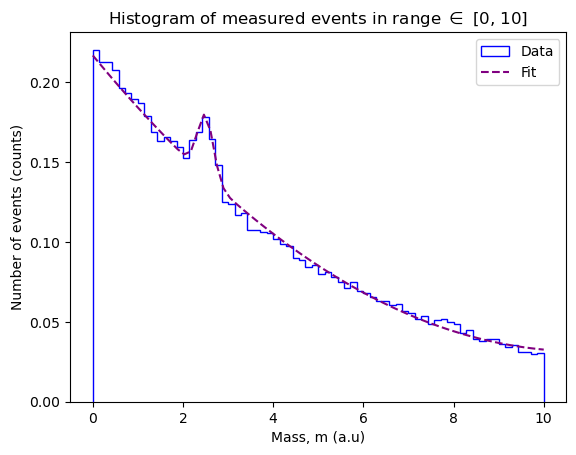

In [15]:
# Compute the predictied y values of the fit (Values are normalised)
fit_line = fit_function._evaluate(X_VALUES) / fit_function.integrate(X_BOUNDS)

# Plot histogram with fit
plt.hist(events, bins=N_BINS, histtype="step", color="blue", label="Data", density=True) 
plt.plot(X_VALUES, fit_line, ls="--", c="purple", label="Fit")
plt.xlabel("Mass, m (a.u)")
plt.ylabel(f"Number of events (counts)")
plt.title(r"Histogram of measured events in range $\in$ [0, 10]")
plt.legend()

## Question 3

We will now attempt to fit the data with a gaussian signal + exponential background.

We expect the parameter values to be around:
* Background fraction = 0.98
* Mean = 2.5
* Slope/intercept = -0.09
* We fix intercept = 1.0 

In [16]:
# Define initial parameters of fit in a dictionary
initial_parameter_dict = {
    "backgroundFraction":       0.96,
    "mean":                     2.0,
    "sigma":                    0.5,
    "slope":                    -0.05,
    "intercept":                1.0,
}

# Initialise objects for pdf (object with function we want to fit) and the fitting statistic (nnl)
# We set the values of the parameter when initialising object to 1 as they will be overritien by the init param dict
fit_function = GaussianWithLinear(
    backgroundFraction=1.0, mean=1.0, sigma=1.0, slope=1.0, intercept=1.0, bounds=X_BOUNDS,
)
fit_statistic = NegativeLogLikelihood(fit_function, events)

# Initialise iminuit minimiser object
minimiser = Minuit(
    fit_statistic.evaluateSignalWithLinear,
    **initial_parameter_dict,
)
# Set the error diff to 0.5 as we are using negative log likelyhood
minimiser.errordef = 0.5

# Fix the value of intercept to 1.0
minimiser.fixed["intercept"] = True

# Apply resonable limits to parameters
minimiser.limits = [(0.7, 1.0), (2.0, 3.0), (0.0, 0.4), (-0.2, 0.0), (None, None)] 

# Minimise the fit_statistic
result = minimiser.migrad()

# Output minimisation results
result

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2.155e+05                  │              Nfcn = 234              │
│ EDM = 1.6e-05 (Goal: 0.0001)     │            time = 0.4 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name               │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ backgroundFraction │   0.900   │   0.007   │            │            │   0.7   │    1    │       │
│ 1 │ mean               │   2.465   │   0.016   │            │            │    2    │    3    │       │
│ 2 │ sigma              │   0.200   │   0.016   │            │            │    0    │   0.4   │       │
│ 3 │ slope              │ -90.40e-3 │  0.22e-3  │            │            │  -0.2   │    0    │       │
│ 4 │ intercept          │   1.00    │   0.01    │            │            │         │         │  yes  │
└───┴────────────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────────────────┬────────────────────────────────────────────────────────────────────────────────────────────────┐
│                    │ backgroundFraction               mean              sigma              slope          intercept │
├────────────────────┼────────────────────────────────────────────────────────────────────────────────────────────────┤
│ backgroundFraction │            4.5e-05            0.03e-3           -0.06e-3           -0.30e-6                  0 │
│               mean │            0.03e-3           0.000266           -0.10e-3           -0.21e-6                  0 │
│              sigma │           -0.06e-3           -0.10e-3           0.000264            0.42e-6                  0 │
│              slope │           -0.30e-6           -0.21e-6            0.42e-6           5.04e-08                  0 │
│          intercept │                  0                  0                  0                  0                  0 │
└────────────────────┴────────────────────────────────────────────────────────────────────────────────────────────────┘

In [17]:
# Define list containing all parameter names
parameter_names = initial_parameter_dict.keys()
# Define list containing all optimised parameter values
optimised_parameter_vals = [result.values[key] for key in parameter_names]
# Define list containing all optimised parameter errors
optimised_parameter_errors = [result.errors[key] for key in parameter_names]
# Define liust containing units of each parameter
parameter_units = ["", "a.u", "a.u", "a.u", "",]

# Print out results
for idx, name in enumerate(parameter_names):
    print(f"The optimised value fo {name} +/- statistical error is:  {optimised_parameter_vals[idx]:.2f} +/- {optimised_parameter_errors[idx]:.2f} {parameter_units[idx]}\n")

The optimised value fo backgroundFraction +/- statistical error is:  0.90 +/- 0.01 

The optimised value fo mean +/- statistical error is:  2.47 +/- 0.02 a.u

The optimised value fo sigma +/- statistical error is:  0.20 +/- 0.02 a.u

The optimised value fo slope +/- statistical error is:  -0.09 +/- 0.00 a.u

The optimised value fo intercept +/- statistical error is:  1.00 +/- 0.01 



In [21]:
# Add error of mean to dictionary
mean_statistical_errors["gaussian_with_linear"] = result.errors["mean"]

# Add minimiised mean to dictionary
optimised_means["gaussian_with_linear"] = result.values["mean"]

# Compute the systematic error of the mean
mean_systematic_error = abs(optimised_means["gaussian_with_linear"] - optimised_means["gaussian_with_exponential"])

# Compute the total error on the mean
mean_total_error = np.sqrt(mean_statistical_errors["gaussian_with_linear"]**2 + mean_systematic_error**2)

# Output the gaussian mean with errors
print(f"The optimised value of mean +/- E_stat +/- E_syst is:  {result.values['mean']:.3f} +/- {optimised_parameter_errors[idx]:.3f} a.u +/- {mean_systematic_error:.3f} a.u")
print(f"The optimised value of mean +/- E_tot is:  {result.values['mean']:.3f} +/- {mean_total_error:.3f} a.u")

The optimised value of mean +/- E_stat +/- E_syst is:  2.465 +/- 0.010 a.u +/- 0.034 a.u
The optimised value of mean +/- E_tot is:  2.465 +/- 0.038 a.u



Plot the distribution allong with the fit

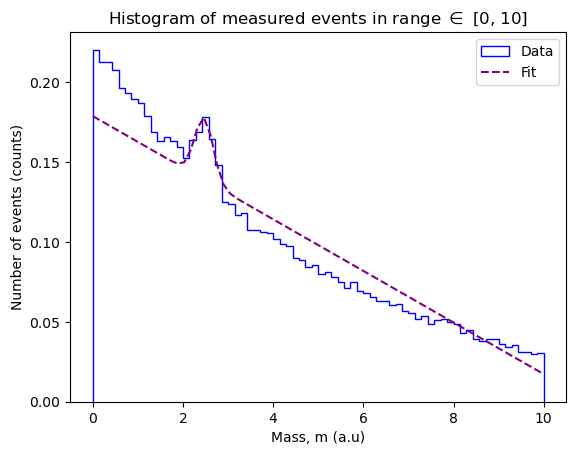

In [19]:
# Compute the predictied y values of the fit (Values are normalised)
fit_line = fit_function._evaluate(X_VALUES) / fit_function.integrate(X_BOUNDS)

# Plot histogram with fit
plt.hist(events, bins=N_BINS, histtype="step", color="blue", label="Data", density=True) 
plt.plot(X_VALUES, fit_line, ls="--", c="purple", label="Fit")
plt.xlabel("Mass, m (a.u)")
plt.ylabel(f"Number of events (counts)")
plt.title(r"Histogram of measured events in range $\in$ [0, 10]")
plt.legend()